# Faster RCNN 






## Импорт библиотек

In [ ]:
# Для загрузки и анализа данных
import os
import tarfile
import urllib.request
import glob
import pandas as pd
import numpy as np
import xml.etree.ElementTree as ET
from tqdm import tqdm
from sklearn import preprocessing
from time import time

# Для работы с изображениями
import torchvision
from torchvision import transforms
from albumentations.pytorch import ToTensor
from torch.utils.data import DataLoader, Dataset
from PIL import Image
from albumentations import (HorizontalFlip, ShiftScaleRotate, VerticalFlip, Normalize,Flip,
                            Compose, GaussNoise)
import cv2
import matplotlib.pyplot as plt
from IPython.display import display


# Для построения модели
import torch
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

## Загрузка данных

Мы будем использовать набор данных PASCAL Visual Object Classes ([VOC](http://host.robots.ox.ac.uk/pascal/VOC/index.html)), в котором присутствует 20 кдассов изображений. 

На этот раз мы скачаем датасет и сохраним изображения 2010 года в cvs файл. 

In [ ]:
# Загрузка датасета
if not os.path.exists("VOCdevkit"):
    if not os.path.exists("VOC.tar"):
        urllib.request.urlretrieve(
            "https://pjreddie.com/media/files/VOCtrainval_11-May-2012.tar", "VOC.tar"
        )
    with tarfile.open("VOC.tar") as tar:
        tar.extractall()

Экспортируем информацию из аннотаций с помощью функции `xml_to_csv`.

In [ ]:
def xml_to_csv(path = 'VOCdevkit/VOC2012/Annotations/'):
    xml_list = []
    for xml_file in tqdm(glob.glob(path + '/2010*.xml')):
        tree = ET.parse(xml_file)
        root = tree.getroot()
        for obj in root.findall('object'):
            bbx = obj.find('bndbox')
            xmin = int(bbx.find('xmin').text)
            ymin = int(bbx.find('ymin').text)
            xmax = int(bbx.find('xmax').text)
            ymax = int(bbx.find('ymax').text)
            label = obj.find('name').text

            value = (root.find('filename').text,
                     int(root.find('size')[0].text),
                     int(root.find('size')[1].text),
                     int(root.find('size')[2].text),
                     label,
                     xmin,
                     ymin,
                     xmax,
                     ymax
                     )
            xml_list.append(value)
    column_name = ['filename', 'channels', 'width', 'height',
                   'class', 'xmin', 'ymin', 'xmax', 'ymax']
    xml_df = pd.DataFrame(xml_list, columns=column_name)
    return xml_df

Сохраним полученную информацию в VOC_2010.csv файл.

In [ ]:
xml_df = xml_to_csv()
xml_df.to_csv('VOC_2010.csv', index=None)
print('Successfully converted xml to csv.')

100%|██████████| 3503/3503 [00:00<00:00, 9717.91it/s]


Successfully converted xml to csv.


In [ ]:
xml_df.head()

,filename,channels,width,height,class,xmin,ymin,xmax,ymax
0,2010_004698.jpg,3,375,500,person,382,37,452,131
1,2010_004698.jpg,3,375,500,person,258,109,500,375
2,2010_004698.jpg,3,375,500,person,1,140,356,375
3,2010_004698.jpg,3,375,500,person,1,39,233,286
4,2010_006979.jpg,3,375,500,person,236,84,379,323


Отберем только 100 сэмплов для упрощения обучения модели 

In [ ]:
xml_df = xml_df[:100]

In [ ]:
print(f'Общее количество объектов {xml_df.shape[0]}')
print(f'Количество изображений в датафрэйме {len(np.unique(xml_df["filename"]))}')

Общее количество объектов 100
Количество изображений в датафрэйме 42


## Обработка данных 

Закодируем классы обьектов.

In [ ]:
le = preprocessing.LabelEncoder()
xml_df['class'] = le.fit_transform(xml_df['class'])

In [ ]:
xml_df.head()

,filename,channels,width,height,class,xmin,ymin,xmax,ymax
0,2010_004698.jpg,3,375,500,11,382,37,452,131
1,2010_004698.jpg,3,375,500,11,258,109,500,375
2,2010_004698.jpg,3,375,500,11,1,140,356,375
3,2010_004698.jpg,3,375,500,11,1,39,233,286
4,2010_006979.jpg,3,375,500,11,236,84,379,323


Разделим выборку на train и val.

In [ ]:
image_ids = xml_df['filename'].unique()
train_ids = image_ids[0:int(0.8*len(image_ids))]
val_ids = image_ids[int(0.8*len(image_ids)):]
print(f'# изображение {len(image_ids)}')
print(f'# train изображений {len(train_ids)}')
print(f'# val изображений {len(val_ids)}')

# изображение 42
# train изображений 33
# val изображений 9


In [ ]:
train_df = xml_df[xml_df['filename'].isin(train_ids)]
val_df = xml_df[xml_df['filename'].isin(val_ids)]

Вспомогательная функция для аугментации данных.

In [ ]:
def get_transforms(phase):
            list_transforms = []
            if phase == 'train':
                  list_transforms.extend([
                                          Flip(p=0.5)
                                        ])
            list_transforms.extend(
                [
                 ToTensor(),
                ])
            list_trfms = Compose(list_transforms,
                                 bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']})
            return list_trfms

Напишем класс `VOC_2010()` для загрузки данных в модель.

In [ ]:
class VOC_2010(Dataset):
    def __init__(self, df, image_dir, phase='train'):
        super().__init__()
        self.df = df
        self.image_dir = image_dir
        self.images = df['filename'].unique()
        self.transforms = get_transforms(phase)
        
        
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self,idx):
        image = self.images[idx]
        image_id = str(image.split('.')[0])
        
        image_arr = cv2.imread(os.path.join(self.image_dir,image), cv2.IMREAD_COLOR)
        image_arr = cv2.cvtColor(image_arr, cv2.COLOR_BGR2RGB).astype(np.float32)

        # Нормализация данных
        image_arr /= 255.0

        point = self.df[self.df['filename'] == image]
        boxes = point[['xmin', 'ymin', 'xmax', 'ymax']].values
        
        # Площадь внутри bbox
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        area = torch.as_tensor(area, dtype=torch.float32)
        
        # Запишем класс объекта в переменную label
        labels = torch.as_tensor(point['class'].values, dtype=torch.int64)
        
        target = {}
        target['boxes'] = boxes
        target['labels'] = labels
        target['image_id'] = torch.tensor(idx)
        target['area'] = area
        
        if self.transforms:
            sample = {
                'image': image_arr,
                'bboxes': target['boxes'],
                'labels': target['labels']
            }
            sample = self.transforms(**sample)
            image = sample['image']
            
        target['boxes'] = torch.stack(tuple(map(torch.tensor, 
                                                zip(*sample['bboxes'])))).permute(1, 0)
        
        return image, target, image_id
            

In [ ]:
train_dir = 'VOCdevkit/VOC2012/JPEGImages/'

train_data = VOC_2010(train_df, train_dir, phase='train')
val_data = VOC_2010(val_df, train_dir, phase='validation')

print(f'Размер обучающей выборки {len(train_data)}')
print(f'Размер валидационной выборки {len(val_data)}')

Размер обучающей выборки 33
Размер валидационной выборки 9


In [ ]:
batch = 4

def collate_fn(batch):
    return tuple(zip(*batch))

train_data_loader = DataLoader(
    train_data,
    batch_size=batch,
    shuffle=False,
    collate_fn=collate_fn
)

valid_data_loader = DataLoader(
    val_data,
    batch_size=batch,
    shuffle=False,
    collate_fn=collate_fn
)

## Визуализация данных

In [ ]:
def image_convert(image):
    image = image.clone().cpu().numpy()
    image = image.transpose((1,2,0))
    image = (image * 255).astype(np.uint8)
    return image

def plot_img(data,idx):
    img = data.__getitem__(idx)
    image = image_convert(img[0])
    image = np.ascontiguousarray(image)
    bbox = img[1]['boxes'].numpy()
    for i in bbox:
        cv2.rectangle(image, (int(i[0]),int(i[1])), (int(i[2]),int(i[3])), (0,255,0), thickness=2)
    plt.figure(figsize=(10,10))
    plt.imshow(image)

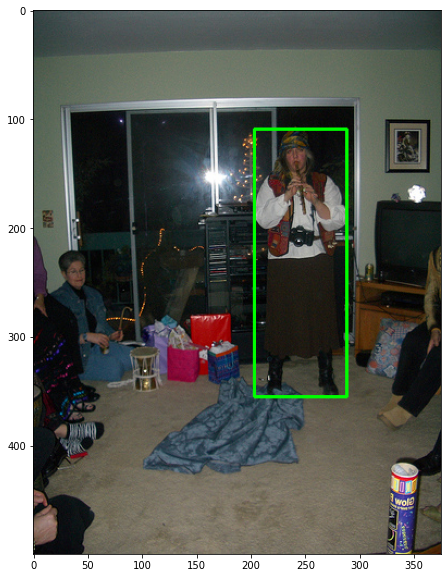

In [ ]:
plot_img(train_data,5)

### Задание

Отрисуйте 1 батч изображений с bbox.

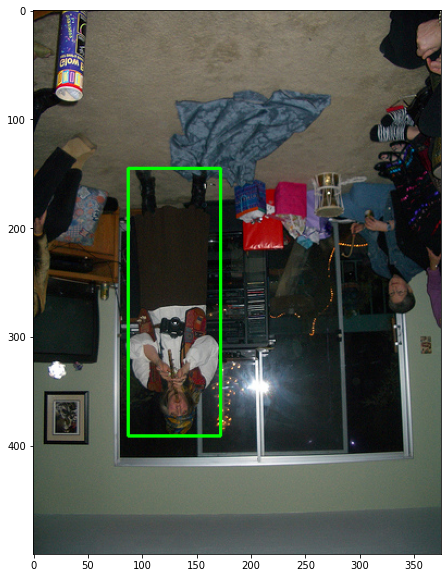

In [ ]:
batch = 1

def collate_fn(batch):
    return tuple(zip(*batch))

train_data_loader = DataLoader(
    train_data,
    batch_size=batch,
    shuffle=False,
    collate_fn=collate_fn
)

valid_data_loader = DataLoader(
    val_data,
    batch_size=batch,
    shuffle=False,
    collate_fn=collate_fn
)

#Визуализация:

def image_convert(image):
    image = image.clone().cpu().numpy()
    image = image.transpose((1,2,0))
    image = (image * 255).astype(np.uint8)
    return image

def plot_img(data,idx):
    img = data.__getitem__(idx)
    image = image_convert(img[0])
    image = np.ascontiguousarray(image)
    bbox = img[1]['boxes'].numpy()
    for i in bbox:
        cv2.rectangle(image, (int(i[0]),int(i[1])), (int(i[2]),int(i[3])), (0,255,0), thickness=2)
    plt.figure(figsize=(10,10))
    plt.imshow(image)
    
plot_img(train_data,5)

## Загрузка модели

In [ ]:
device = torch.device('cpu')

In [ ]:
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)

Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth


  0%|          | 0.00/160M [00:00<?, ?B/s]

In [ ]:
num_classes = len(np.unique(xml_df['class'])) 
print(f'Число классов: {num_classes}')

# Получим число входных признаков для классификатора
in_features = model.roi_heads.box_predictor.cls_score.in_features

# Заменим классификатор на новый
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

Число классов: 16


In [ ]:
images, targets, ids = next(iter(train_data_loader))
images = list(image.to(device) for image in images)
targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

In [ ]:
model.to(device)
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005)

## Обучение

In [ ]:
num_epochs = 3
train_loss_min = 0.9
total_train_loss = []


for epoch in tqdm(range(num_epochs)):
    print(f'Epoch :{epoch + 1}')
    start_time = time()
    train_loss = []
    model.train()
    for images, targets, image_ids in train_data_loader:
        
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        loss_dict = model(images, targets)

        losses = sum(loss for loss in loss_dict.values())
        train_loss.append(losses.item())        
        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

    epoch_train_loss = np.mean(train_loss)
    print('epoch_train_loss', epoch_train_loss)
    total_train_loss.append(epoch_train_loss)
    print(f'Epoch train loss is {epoch_train_loss}')

    
    time_elapsed = time() - start_time
    print('{:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))

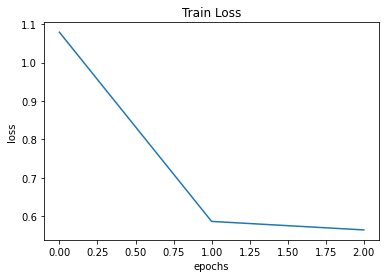

In [ ]:
plt.title('Train Loss')
plt.plot(total_train_loss)
plt.xlabel('epochs')
plt.ylabel('loss')
plt.show()